# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
import pickle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
import xgboost as xgb

[nltk_data] Downloading package stopwords to C:\Users\Haneen
[nltk_data]     Ibrahim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Haneen
[nltk_data]     Ibrahim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Haneen Ibrahim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# preprocessing Functions

# Cleaning


In [2]:
def dropColumns(df, lst):
    for col in lst:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

In [3]:
def PreprocessListCategories(df, lst):
    for col in lst:
      # Apply one-hot encoding to the "col" column in list and put the output in newdf
      newdf = df[col].str.get_dummies(sep=', ')
      df.drop(columns=[col], inplace=True)
      # Concatenate the one-hot encoded columns with the original DataFrame
      df = pd.concat([df, newdf], axis=1)     
    return df

In [4]:
def CheckNullRows(df):
    missing_rows = df.isnull().any(axis=1).sum()
    print('Number of rows that have null values: ', missing_rows)

In [5]:
def DropNullRows(df):
    df.dropna(inplace=True)
    

In [6]:
def PreProcessAgrRating(df):
    # Age Rating 
    # Print current data type
    print('Data type of Age Rating is, ', df['Age Rating'].dtype)
    # Remove the + sign
    df['Age Rating'] = df['Age Rating'].str.replace('+', '', regex=False)
    # Convert Column datatype to int
    df['Age Rating'] = df['Age Rating'].astype(int)
    print('Data type of Age Rating after processing is ', df['Age Rating'].dtype)
    # Create a dictionary to map the age ratings to integers
    age_rating_map = {4: 1, 9: 2, 12: 3, 17: 4}
    # Replace each value with its category
    df['Age Rating'] = df['Age Rating'].replace(age_rating_map)
    # Print Age Rating
    print(df['Age Rating'].head())
    

In [7]:
def ConvertToDateTime(df, lst):
    for col in lst:
        df[col] = pd.to_datetime(df[col].astype('datetime64'),dayfirst=True).astype('int64')

In [8]:
def GetColumnsNullsPerc(df):
    # print count of nulls for each column and percentage of them
    missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().mean())*100})
    return missing_data

In [9]:
def CheckListOfCategoriesColumn(df, col):
    print("Data type of ", col, "column is: ", df[col].dtype)
    all_languages = list(set(','.join(df['Languages'].fillna('').unique()).split(',')))
    print(col, "column has ", len(all_languages), "unique", col)

In [10]:
def PrintDfColumns(df):
    columns_list = df.columns.tolist()
    print(columns_list)

In [11]:
def FillColumnNulls(df, col):
    df[col] = df[col].fillna(0)
    

In [12]:
def DuplicatesDetectionAndRemoval(df):
    print("Number of duplicates rows: ", df.duplicated().sum())
    df.drop_duplicates(inplace = True, keep="first")
    

In [13]:
def outliers(dataset,col):
    fig, ax =plt.subplots(1,2)
    sns.boxplot( y=col, data=dataset,color="red", ax=ax[0])
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    dataset[col]=dataset[col].apply(lambda x: upper_bound if x> upper_bound else( lower_bound if x< lower_bound  else x))        
    sns.boxplot( y=col, data=dataset,color="blue", ax=ax[1])
    fig.show()
    

In [14]:
def avarage_Purchases(data,col):
    data[col]=data[col].fillna("0")
    data[col]=data[col].astype(str)
    data[col]=data[col].str.split(",")
    data[col]=[np.float64(x) for x in data[col]]
    data[col]=data[col].apply(lambda x: mean(x))
    data[col]=data[col].astype(float)
    return data

In [15]:
def reduceOHEColumns(df):
    X = df.iloc[:,7:] #columns of categories [languages, generes, ]
    zero_percentage = pd.DataFrame({'total_zeros': (X == 0).sum(), 'perc_zeros': (X == 0).mean() * 100})
    to_keep = zero_percentage['perc_zeros'] < 90
    
    updatedX = X.loc[:, to_keep]
    df = df.drop(df.columns[18:], axis=1)
    
    result = pd.concat([df, updatedX], axis=1)
    return result

In [16]:
def cleaning(df):
  PreProcessAgrRating(df)
  ConvertToDateTime(df, ['Original Release Date', 'Current Version Release Date'])
  df.drop(columns=['Subtitle'], inplace=True)
  FillColumnNulls(df, 'In-app Purchases')
  df = avarage_Purchases(df, 'In-app Purchases')
  outliarlist=["User Rating Count","Size"]
  for i in outliarlist:
    outliers(df,i)
  df = PreprocessListCategories(df,['Primary Genre', 'Genres','Languages'])
  return df

# Feature Transformation

In [17]:
def extract_country(links):
    us_words = []
    for link in links:
        parsed_url = urlparse(link)
        try:
            us_word = parsed_url.path.split('/')[1]
            us_words.append(us_word)
        except IndexError:
            print(f"Malformed link: {link}")
    return us_words

In [18]:
def extract_color(links):
    is_color_list = []
    for link in links:
        parsed_url = urlparse(link)
        netloc = parsed_url.netloc.lower()
        is_color_match = re.search(r"is\d", netloc)
        if is_color_match:
            is_color = is_color_match.group()
        else:
            is_color = None
        is_color_list.append(is_color)
    return is_color_list

In [19]:
def frequent_words_in_name(df):
    # Define the stop words list
    stop_words = set(stopwords.words('english'))
    # Create an empty Counter object to store the word frequencies
    word_freq = Counter()
    # Iterate over each row in the 'Name' column
    for name in df['Name']:
        # Check if the value is a string before tokenizing it
        if isinstance(name, str):
            # Tokenize the name string into words
            words = word_tokenize(name)

            # Filter out stop words and iterate over each word
            for word, pos in nltk.pos_tag(words):
                # Filter out stop words and check if the word is a noun or verb
                if word not in stop_words and (pos.startswith('N') or pos.startswith('V')):
                    # Add the word to the counter
                    word_freq[word.lower()] += 1

    # Get the 50 most frequent words
    most_common_words = [word[0] for word in word_freq.most_common(50)]
    with open('file.pkl', 'wb') as file:
      pickle.dump(most_common_words,file)

In [20]:
def set_freq_words(df):
  with open('file.pkl', 'rb') as file:
    most_common_words = pickle.load(file)
  df['Name'] = df['Name'].apply(
        lambda x: sum(1 for word in word_tokenize(str(x).lower()) if word in most_common_words) + 1)
  return df

In [21]:
def count_dev_games(df):
  # Create a dictionary to store the frequency of each developer
  developer_freq = df['Developer'].value_counts().to_dict()
  with open('dev.pkl', 'wb') as file:
      pickle.dump(developer_freq,file)

In [22]:
def replace_dev_games(df):
  with open('dev.pkl', 'rb') as file:
    developer_freq = pickle.load(file)
  # Replace each developer name with its frequency in the dataset
  df['Developer'] = df['Developer'].map(developer_freq)
  return df

In [23]:
def calc_duration(df):
  # Calculate the difference in years and add 1
  df['Years Since Release'] = (df['Current Version Release Date'].dt.year - df['Original Release Date'].dt.year) + 1 # add 1 for each row because if Years Since Release =0 make it 1 to avoid multipy by 0 in training model

In [24]:
def price_range(df):
  df["Price"] = df["Price"].dropna().map(lambda x: "Free" if x == 0.00 else("Low Price" if 0.99 <= x <= 4.99 else("Medium Price" if 5.99 <= x <= 19.99 else "High Price")))
  return df

In [25]:
def scaling(df):
  #use Min-Max scaling, which scales the data to a range between 0 and 1.
  # Initialize the MinMaxScaler object
  scalerA = MinMaxScaler()
  scalerB = MinMaxScaler()
  # Fit and transform the features
  df['User Rating Count'] = scalerA.fit_transform(df[['User Rating Count']])
  df['Size'] = scalerB.fit_transform(df[['Size']])
  with open('sA.pkl', 'wb') as file:
      pickle.dump(scalerA,file)
  with open('sB.pkl', 'wb') as file:
      pickle.dump(scalerB,file)  
  return df

In [26]:
def apply_scaling(df):
    with open('sA.pkl', 'rb') as file:
      scaler_A = pickle.load(file)
    with open('sB.pkl', 'rb') as file:
      scaler_B = pickle.load(file)
    df['User Rating Count'] = scaler_A.transform(df[['User Rating Count']])
    df['Size'] = scaler_B.transform(df[['Size']])

In [27]:
def endcode_price(df):
  age_rating_map = {'Free': 0, 'Low Price': 1,'Medium Price': 2,'High Price': 3}
  df['Price'] = df['Price'].replace(age_rating_map)
  return df

In [28]:
def feature_transformation(df):
    df['Price'] = df['Price'].fillna("0")
    #df['Languages'] = df['Languages'].str.count(',') + 1
    # country name extraction
    #df['URL'] = extract_country(df['URL'])
    #df.rename(columns = {'URL':'Country'}, inplace = True)
    # color extraction
    #df['Icon URL'] = extract_color(df['Icon URL'])
    #df.rename(columns = {'Icon URL':'Color'}, inplace = True)
    # price
    #df = price_range(df)
    #df = endcode_price(df)
    # frequent words in name
    #df = frequent_words_in_name(df)
    #df = set_freq_words(df)
    #df.rename(columns = {'Name':'frequent words in Name'}, inplace = True)
    # number of other games by dev
    #count_dev_games(df)
    #df = replace_dev_games(df)
    #df.rename(columns = {'Developer':'Other by developer'}, inplace = True)
    # duration between orignal and current releases in years
    #calc_duration(df)
    df = scaling(df)
    return df

# Feature Selection

In [29]:
def selection(df,df2):
  df = pd.concat([df, df2], axis=1)
  corr = df.corr()
  top_features = corr.index[abs(corr['Average User Rating'])>0.1]
  top_features = top_features.delete(-1)
  return top_features

# Read Data

In [30]:
df = pd.read_csv('games-regression-dataset.csv')
DropNullRows(df)
DuplicatesDetectionAndRemoval(df)
X = df.iloc[:,:17]
dropColumns(X, ['URL','ID', 'Name', 'Icon URL', 'Description', 'Developer'])
Y = df['Average User Rating']

Number of duplicates rows:  8


# Split Train and Test

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, shuffle=True, random_state=10)

# Preprocess Train Data

Data type of Age Rating is,  object
Data type of Age Rating after processing is  int32
2584    1
1493    1
4050    1
1805    3
1044    2
Name: Age Rating, dtype: int32


C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '19/08/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '18/03/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '30/08/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '24/05/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibra

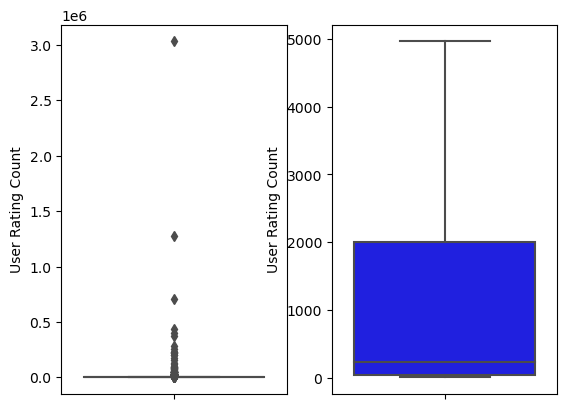

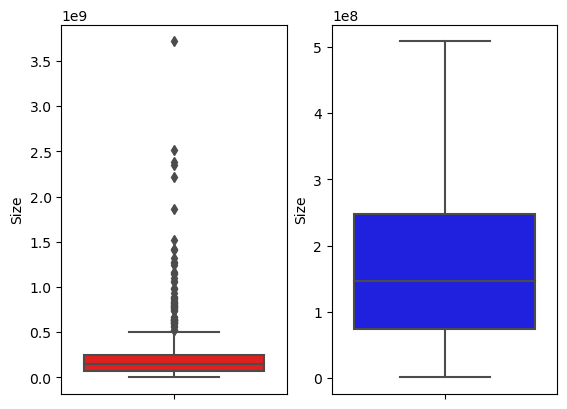

In [32]:
X_train = cleaning(X_train)
X_train = reduceOHEColumns(X_train)

In [33]:
X_train = feature_transformation(X_train)

In [34]:
PrintDfColumns(X_train)
top_f = selection(X_train,Y_train)
print(top_f)
X_train = X_train[top_f]

['User Rating Count', 'Price', 'In-app Purchases', 'Age Rating', 'Size', 'Original Release Date', 'Current Version Release Date', 'Book', 'Games', 'Action', 'Board', 'Entertainment', 'Games', 'Puzzle', 'Role Playing', 'Simulation', 'Strategy', 'DE', 'EN', 'ES', 'FR', 'IT', 'JA', 'KO', 'NL', 'PL', 'PT', 'RU', 'TH', 'TR', 'ZH']
Index(['User Rating Count', 'Original Release Date'], dtype='object')


# Train Models

In [35]:
ModelA = linear_model.LinearRegression()
ModelA.fit(X_train, Y_train)
p = ModelA.predict(X_train)
print("Model A accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelA = pickle.dumps(ModelA)

Model A accurecy Test 0.01156851887879562
Mean Square Error Test 0.29740971410321837


# Preprocess Test Data

Data type of Age Rating is,  object
Data type of Age Rating after processing is  int32
4178    3
1757    1
371     1
3056    1
2078    2
Name: Age Rating, dtype: int32


C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '27/04/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '19/10/2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '16/09/2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '31/01/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibra

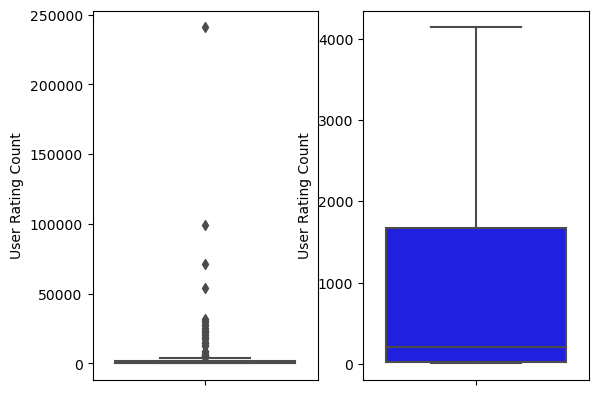

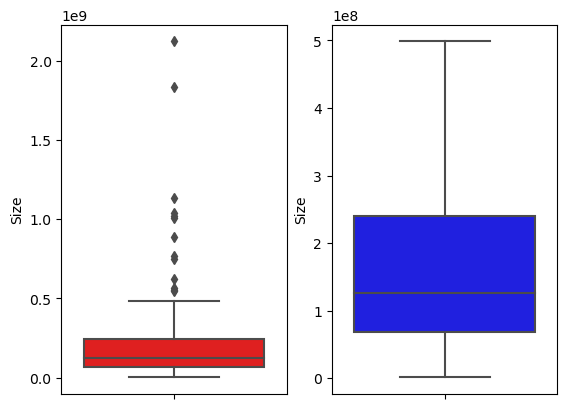

In [36]:
X_test = cleaning(X_test)
X_test = feature_transformation(X_test)
apply_scaling(X_test)
X_test = X_test[top_f]

# Evaluate Models

In [37]:
ModelA = pickle.loads(saved_modelA)
Y_pred = ModelA.predict(X_test)
accuracy = r2_score(Y_test, Y_pred)
print("Model A accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))

Model A accurecy Test 0.014374589812016114
Mean Square Error Test 0.3382383496767792


# Train Models with the whole data set

Data type of Age Rating is,  object
Data type of Age Rating after processing is  int32
0     3
15    1
16    3
22    3
24    1
Name: Age Rating, dtype: int32


C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '25/08/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '14/08/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '27/10/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibrahim\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '16/02/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\Haneen Ibra

Model A accurecy Test 0.01222150503429198
Mean Square Error Test 0.3055913878508464


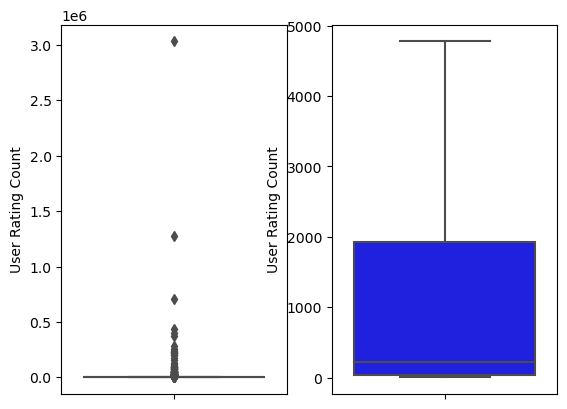

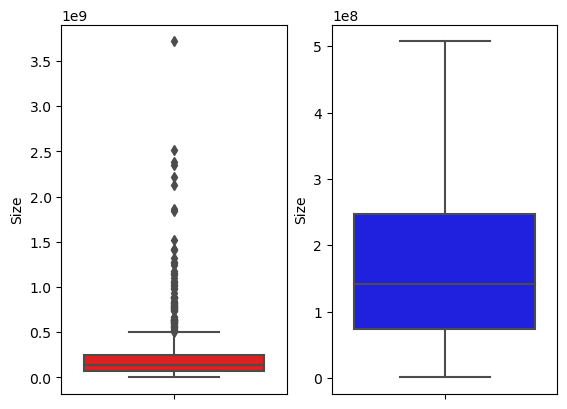

In [38]:
X = cleaning(X)
X = reduceOHEColumns(X)
X = feature_transformation(X)
top_f = selection(X,Y)
X = X[top_f]
ModelA.fit(X, Y)
pFinal = ModelA.predict(X)
print("Model A accurecy Test",r2_score(Y, pFinal))
print('Mean Square Error Test', metrics.mean_squared_error(Y, pFinal))
saved_modelA = pickle.dumps(ModelA)

## SVR Model

In [39]:
from sklearn.svm import SVR
ModelB = SVR()
ModelB.fit(X_train, Y_train)
p = ModelB.predict(X_train)
print("Model B accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelB = pickle.dumps(ModelB)

Model B accurecy Test -0.040436450645527255
Mean Square Error Test 0.3130575191494832


## Decision Tree Model

In [40]:
from sklearn.tree import DecisionTreeRegressor
ModelC = DecisionTreeRegressor()
ModelC.fit(X_train, Y_train)
p = ModelC.predict(X_train)
print("Model C accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelC = pickle.dumps(ModelC)

Model C accurecy Test 0.9982308294086925
Mean Square Error Test 0.000532326751838947


In [41]:
ModelC = pickle.loads(saved_modelC)
Y_pred = ModelC.predict(X_test)
accuracy = r2_score(Y_test, Y_pred)
print("Model C accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))


Model C accurecy Test -2.139966273187184
Mean Square Error Test 1.0775462962962963


In [42]:
ModelC.fit(X, Y)
pFinal = ModelC.predict(X)
print("Model C accurecy Test",r2_score(Y, pFinal))
print('Mean Square Error Test', metrics.mean_squared_error(Y, pFinal))
saved_modelC = pickle.dumps(ModelC)

Model C accurecy Test 0.9974989549951233
Mean Square Error Test 0.0007737542556484061


## Random Forest Model

In [43]:
from sklearn.ensemble import RandomForestRegressor
ModelD = RandomForestRegressor()
ModelD.fit(X_train, Y_train)
p = ModelD.predict(X_train)
print("Model D accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelD = pickle.dumps(ModelD)

Model D accurecy Test 0.8483730043753195
Mean Square Error Test 0.045623133500273895


In [44]:
ModelC = pickle.loads(saved_modelD)
Y_pred = ModelC.predict(X_test)
accuracy = r2_score(Y_test, Y_pred)
print("Model C accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))


Model C accurecy Test -1.4856344013490719
Mean Square Error Test 0.8529983796296294


## K Neighbors Regressor Model

In [45]:
from sklearn.neighbors import KNeighborsRegressor
ModelE = KNeighborsRegressor()
ModelE.fit(X_train, Y_train)
p = ModelE.predict(X_train)
print("Model E accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelE = pickle.dumps(ModelE)

Model E accurecy Test 0.2862072165572399
Mean Square Error Test 0.21477351916376308


In [46]:
ModelC = pickle.loads(saved_modelE)
Y_pred = ModelC.predict(X_test)
accuracy = r2_score(Y_test, Y_pred)
print("Model C accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))


Model C accurecy Test -0.2603035413153456
Mean Square Error Test 0.43249999999999994


## XGBoost Regressor Model

In [50]:
Modelh = xgb.XGBRegressor(objective="reg:linear", random_state=42)
Modelh.fit(X_train, Y_train)
p = Modelh.predict(X_train)
print("Model D accurecy Test",r2_score(Y_train, p))
print('Mean Square Error Test', metrics.mean_squared_error(Y_train, p))
saved_modelh = pickle.dumps(Modelh)

[15:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Model D accurecy Test 0.9519917132439993
Mean Square Error Test 0.014445240880522568


In [51]:
ModelC = pickle.loads(saved_modelh)
Y_pred = ModelC.predict(X_test)
accuracy = r2_score(Y_test, Y_pred)
print("Model C accurecy Test",accuracy)
print('Mean Square Error Test', metrics.mean_squared_error(Y_test, Y_pred))


Model C accurecy Test -1.8241589287800952
Mean Square Error Test 0.9691702805362248
